In [1]:
import numpy as np
np.random.seed(7)
import os
import glob
import cv2
import math
import datetime
import pandas as pd
import random
import time
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss

from matplotlib import pyplot as plt
%matplotlib inline

from joblib import Parallel , delayed

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
size=(64,64)

In [3]:
def process_image(img_file):
    img=cv2.imread(img_file)
    img = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY )

    img=cv2.resize(img,size)
    
    return img #returning reduced image
     

In [4]:
X_train=[]
Y_train=[]

In [5]:
def load_data():
    for j in range(10):
        start=time.time()
        print('load folder c{}'.format(j))
        path=os.path.join('imgs/train','c'+str(j),'*.jpg')
        files=glob.glob(path)
        X_train.extend(Parallel(n_jobs=2)(delayed(process_image)(im_file)
                                          for im_file in files))
        Y_train.extend([j]*len(files))
        end=time.time()-start
        print("Time : % .2f seconds" %end)
    

In [6]:
def normalise_data(train_data,train_target):
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0],  1, 64, 64)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target 


In [7]:
load_data()
train_data,train_target=normalise_data(X_train,Y_train)
data2=[]
for i in range(train_data.shape[0]):
    data2.append([train_data[i],train_target[i]])
data2=np.array(data2)
np.random.shuffle(data2)
final_data=[]
final_target=[]
for each in data2:
    final_data.append(each[0])
    final_target.append(each[1])

final_data=np.array(final_data)
final_target=np.array(final_target)
split_1 = int(0.6 * final_data.shape[0])
split_2 = int(0.8 * final_data.shape[0])
X_train = final_data[:split_1]
Y_train = final_target[:split_1]

X_valid =  final_data[split_1:split_2]
Y_valid = final_target[split_1:split_2]

X_test = final_data[split_2:]
Y_test = final_target[split_2:]


load folder c0
Time :  25.81 seconds
load folder c1
Time :  25.03 seconds
load folder c2
Time :  25.69 seconds
load folder c3
Time :  25.38 seconds
load folder c4
Time :  29.97 seconds
load folder c5
Time :  23.55 seconds
load folder c6
Time :  26.28 seconds
load folder c7
Time :  27.43 seconds
load folder c8
Time :  18.70 seconds
load folder c9
Time :  21.66 seconds
Train shape: (22424, 1, 64, 64)
22424 train samples


In [8]:
X_test.shape

(4485, 1, 64, 64)

In [9]:
train_data = train_data.reshape(train_data.shape[0],  1, 64, 64)

In [10]:
X_train=X_train.reshape(X_train.shape[0],64,64,1)

In [11]:
X_valid=X_valid.reshape(X_valid.shape[0],64,64,1)
X_test=X_test.reshape(X_test.shape[0],64,64,1)

In [14]:
batch_size = 32
n_epochs = 7

In [15]:
def createmodel():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3) , border_mode='same', init='he_normal', 
                            input_shape=(64,64,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, ( 3, 3), border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, (3, 3), border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(8, 8)))#stride is not given default to the pol size
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [16]:
model_driving = createmodel()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=(64, 64, 1...)`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")`
  
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")`
  if sys.path[0] == '':


In [17]:
history=model_driving.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs,
               verbose=1, validation_data=(X_valid, Y_valid))

Train on 13454 samples, validate on 4485 samples
Epoch 1/7
13454/13454 [==============================] - 154s - loss: 2.8863 - acc: 0.1223 - val_loss: 2.2348 - val_acc: 0.2305
Epoch 2/7
13454/13454 [==============================] - 152s - loss: 2.1856 - acc: 0.2052 - val_loss: 1.9116 - val_acc: 0.3683
Epoch 3/7
13454/13454 [==============================] - 150s - loss: 1.8832 - acc: 0.3192 - val_loss: 1.5481 - val_acc: 0.4660
Epoch 4/7
13454/13454 [==============================] - 154s - loss: 1.6230 - acc: 0.4200 - val_loss: 1.2355 - val_acc: 0.6062
Epoch 5/7
13454/13454 [==============================] - 154s - loss: 1.3732 - acc: 0.5166 - val_loss: 1.0681 - val_acc: 0.6332
Epoch 6/7
13454/13454 [==============================] - 152s - loss: 1.1593 - acc: 0.5955 - val_loss: 0.8177 - val_acc: 0.7284
Epoch 7/7
13454/13454 [==============================] - 163s - loss: 1.0140 - acc: 0.6578 - val_loss: 0.6613 - val_acc: 0.7746


In [18]:
from keras.models import model_from_json

In [19]:
model_json=model_driving.to_json()
with open("driving1.json",'w')as json_file:
    json_file.write(model_json)
    
model_driving.save_weights("driver1.h5")

In [20]:
score=model_driving.evaluate(X_test,Y_test,verbose=0)

In [21]:
print(score)

[0.69850437538812526, 0.76098104793756971]


In [22]:
print(history.history.keys())

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


#### plotting

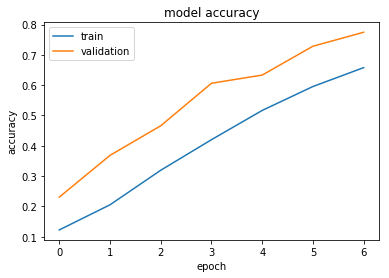

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

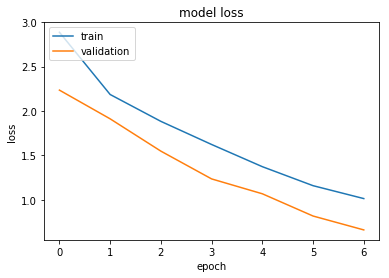

In [24]:
#summarise the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

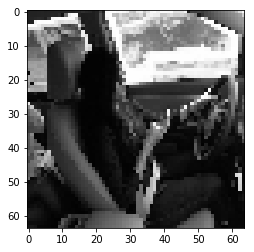

In [46]:
 plt.imshow(np.squeeze(X_train[9]), cmap='gray')

In [47]:
img_to_visualise=X_train[30]
img_to_visualise=np.expand_dims(img_to_visualise,axis=0)

In [27]:
from keras import backend as K

In [40]:
 def layer_to_visualise(layer):
    inputs=[K.learning_phase()] + model_driving.inputs
    _convout1_f=K.function(inputs,[layer.output])
    def convout1_f(X):
        return _convout1_f([0]+[X])
    convolutions=convout1_f(img_to_visualise)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(20,20))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

Shape of conv: (64, 64, 32)


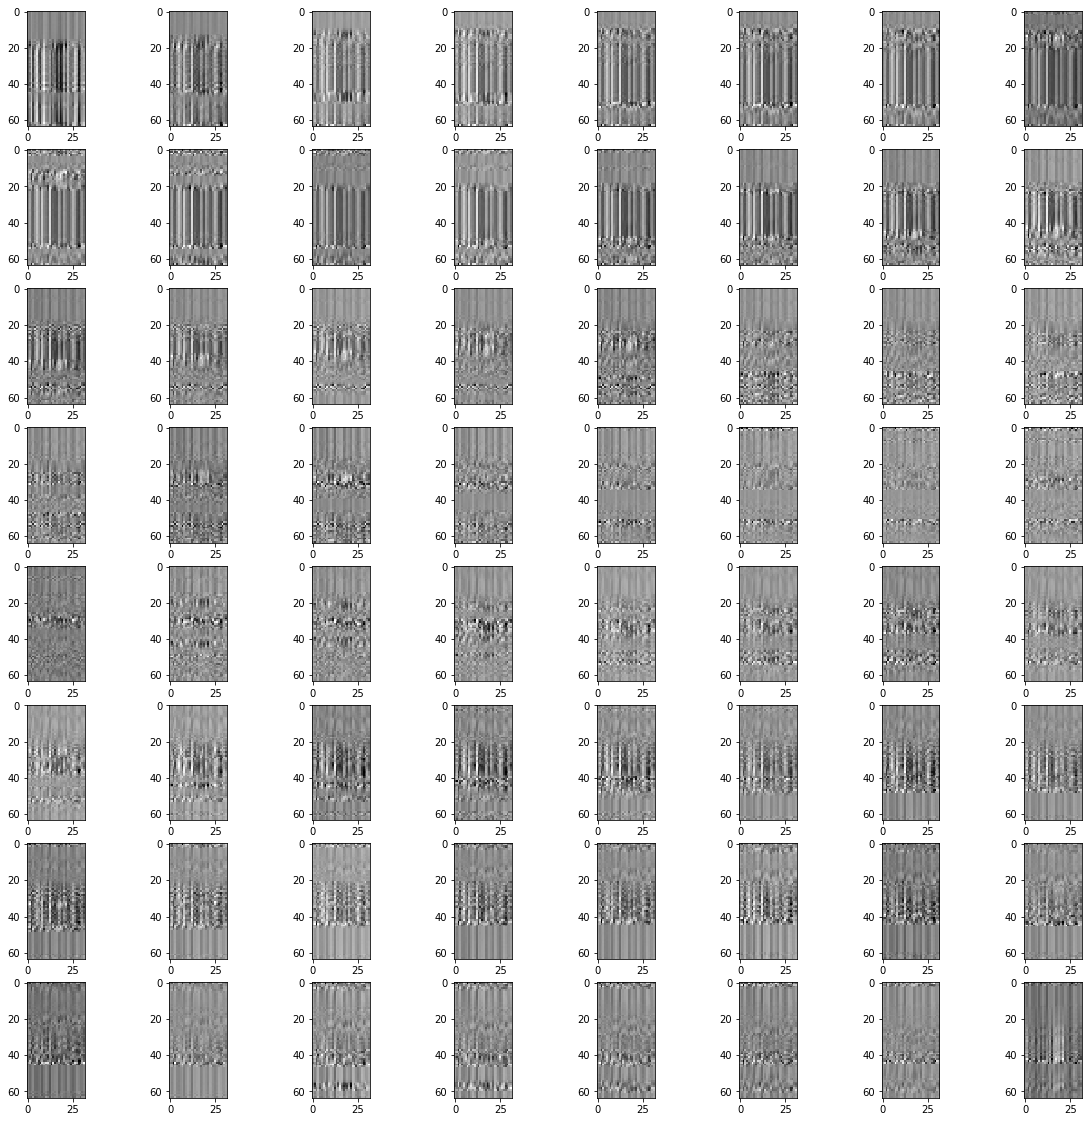

In [48]:
 layer_to_visualise(model_driving.layers[0])

Shape of conv: (32, 32, 32)


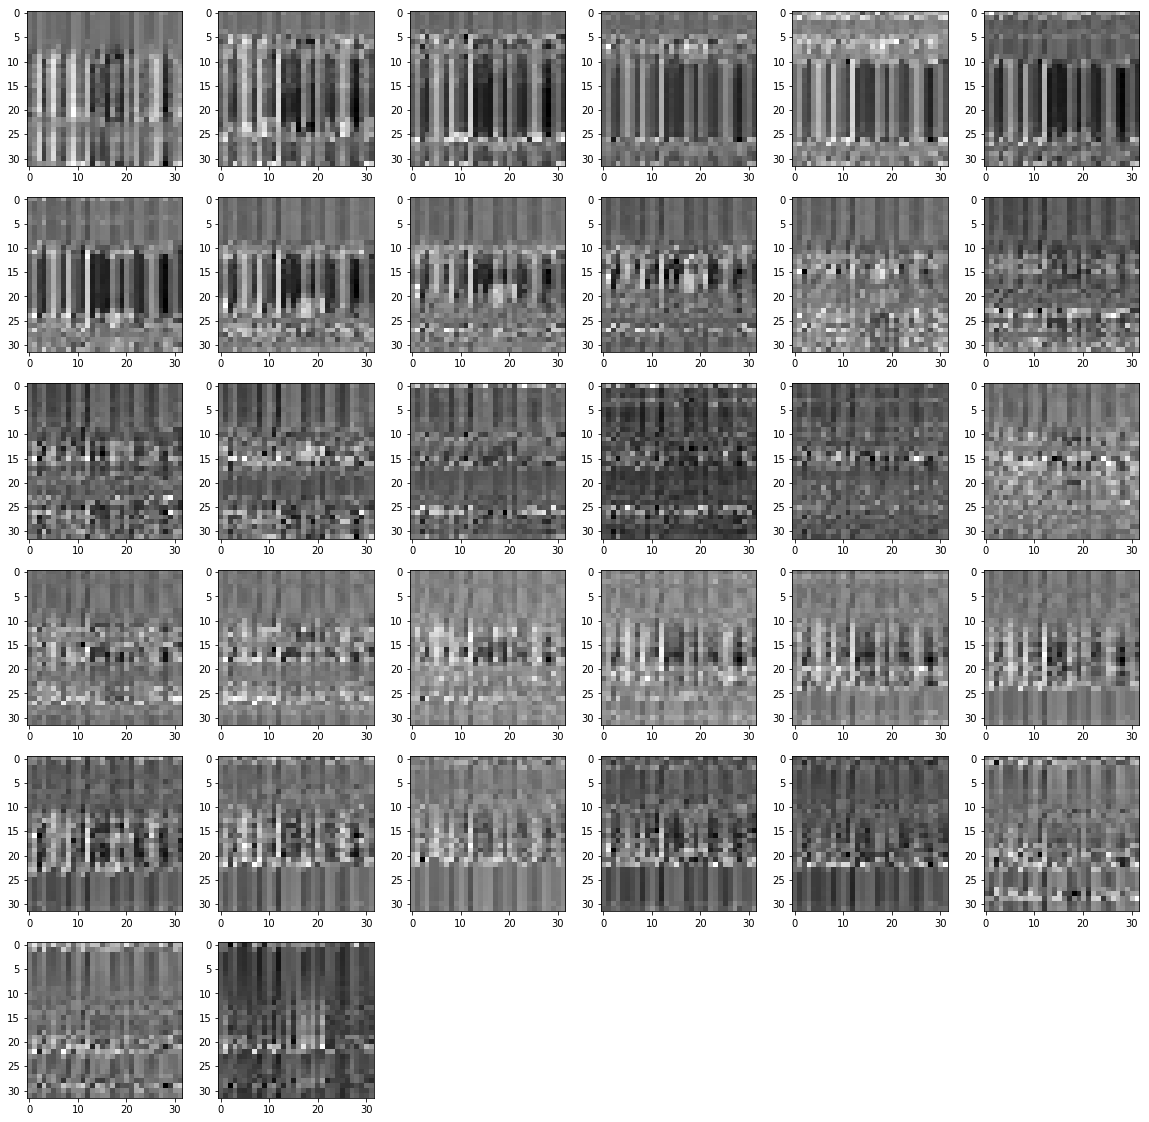

In [49]:
layer_to_visualise(model_driving.layers[1])

Shape of conv: (32, 32, 32)


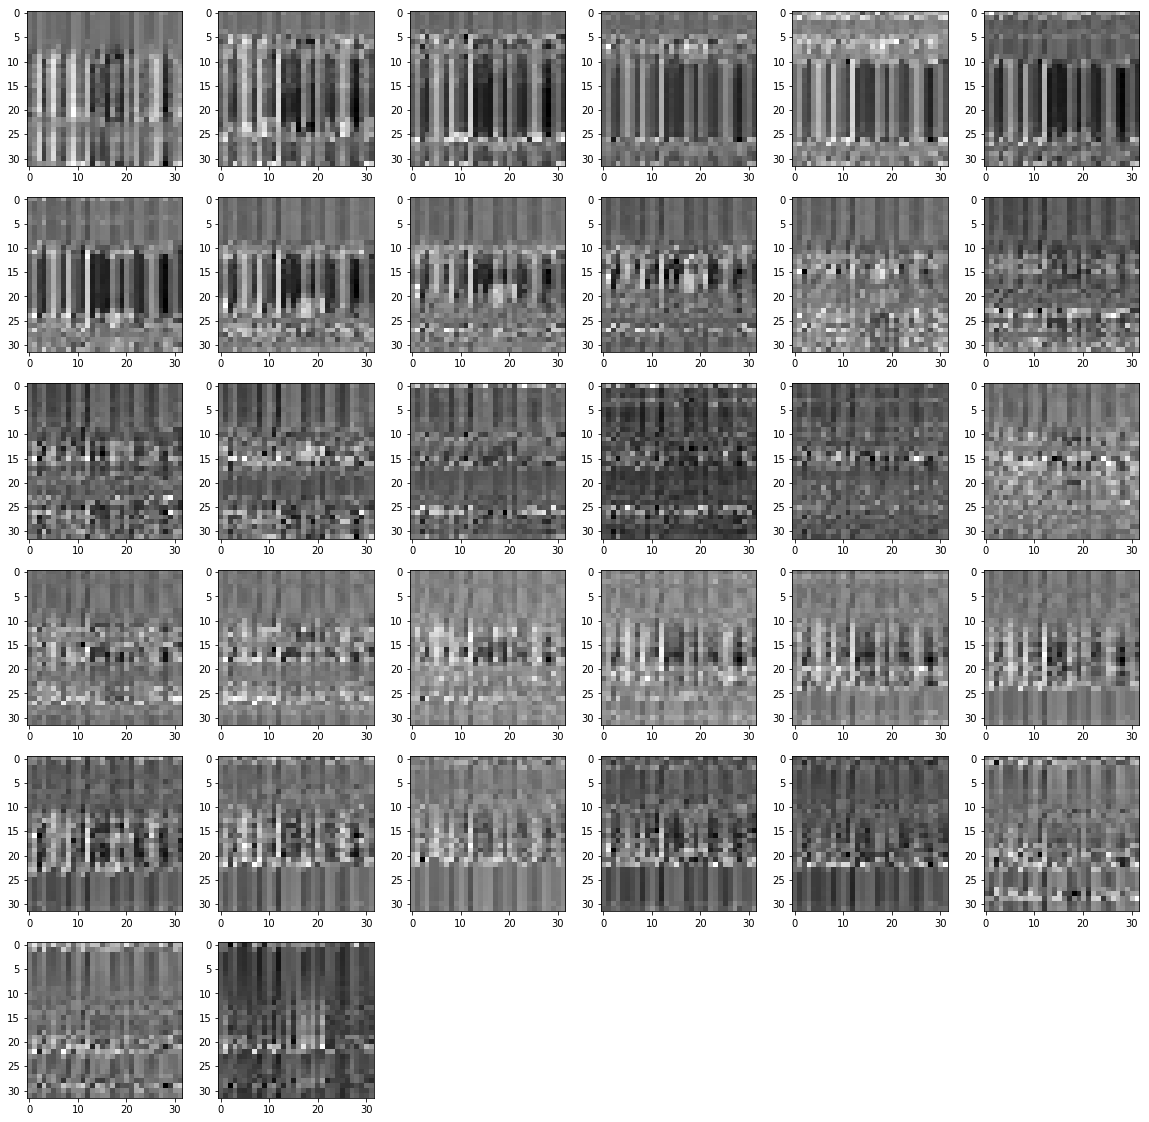

In [50]:
layer_to_visualise(model_driving.layers[2])

Shape of conv: (32, 32, 64)


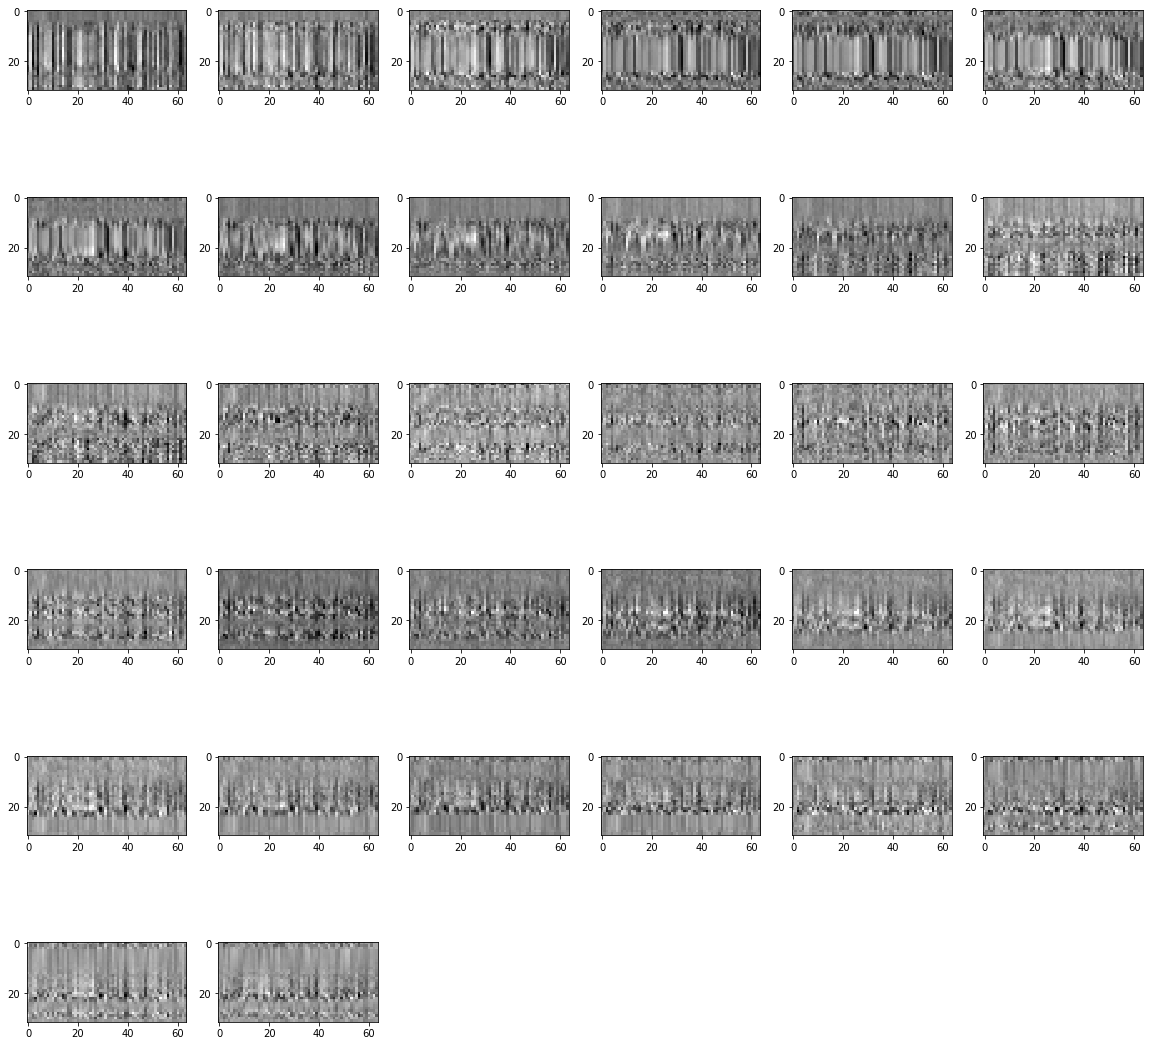

In [52]:
layer_to_visualise(model_driving.layers[3])

Shape of conv: (16, 16, 64)


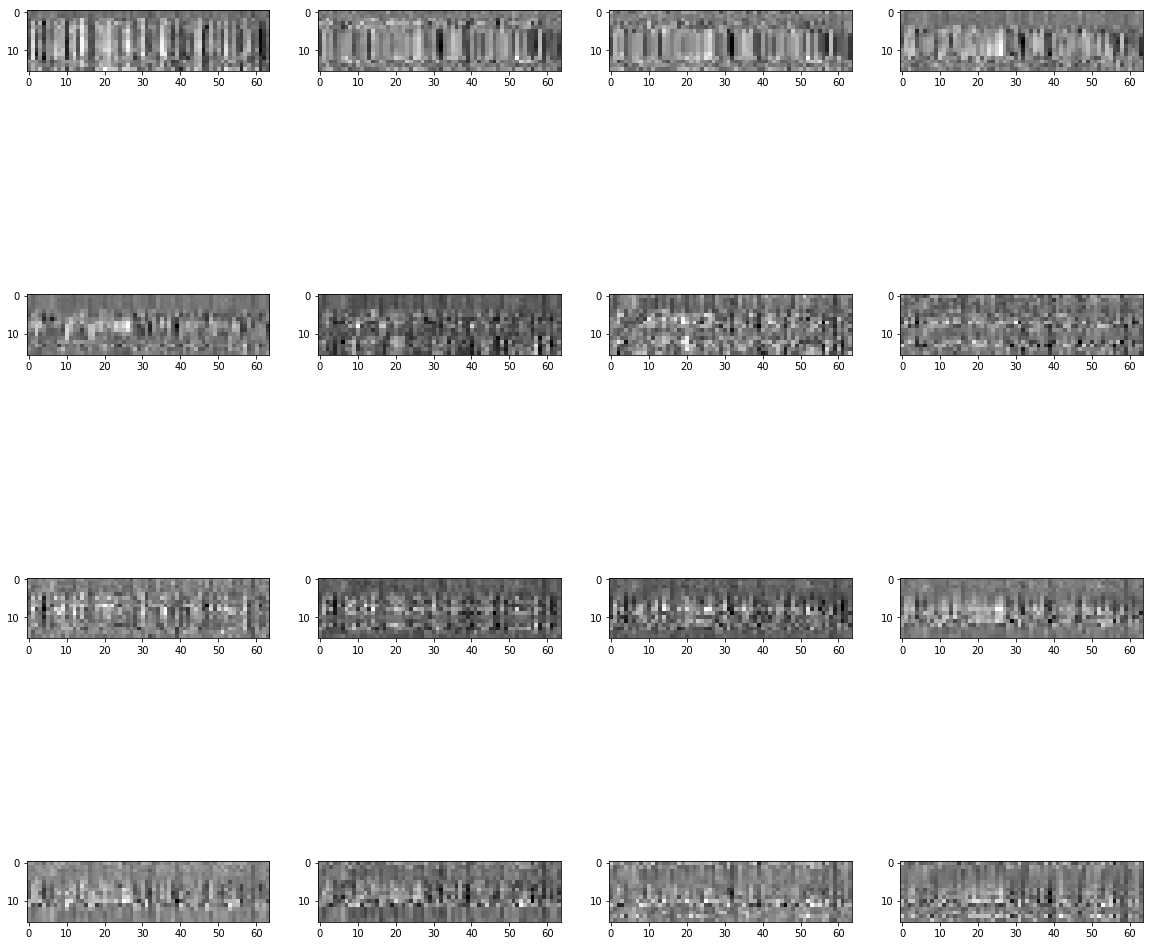

In [53]:
 layer_to_visualise(model_driving.layers[4])

Shape of conv: (16, 16, 64)


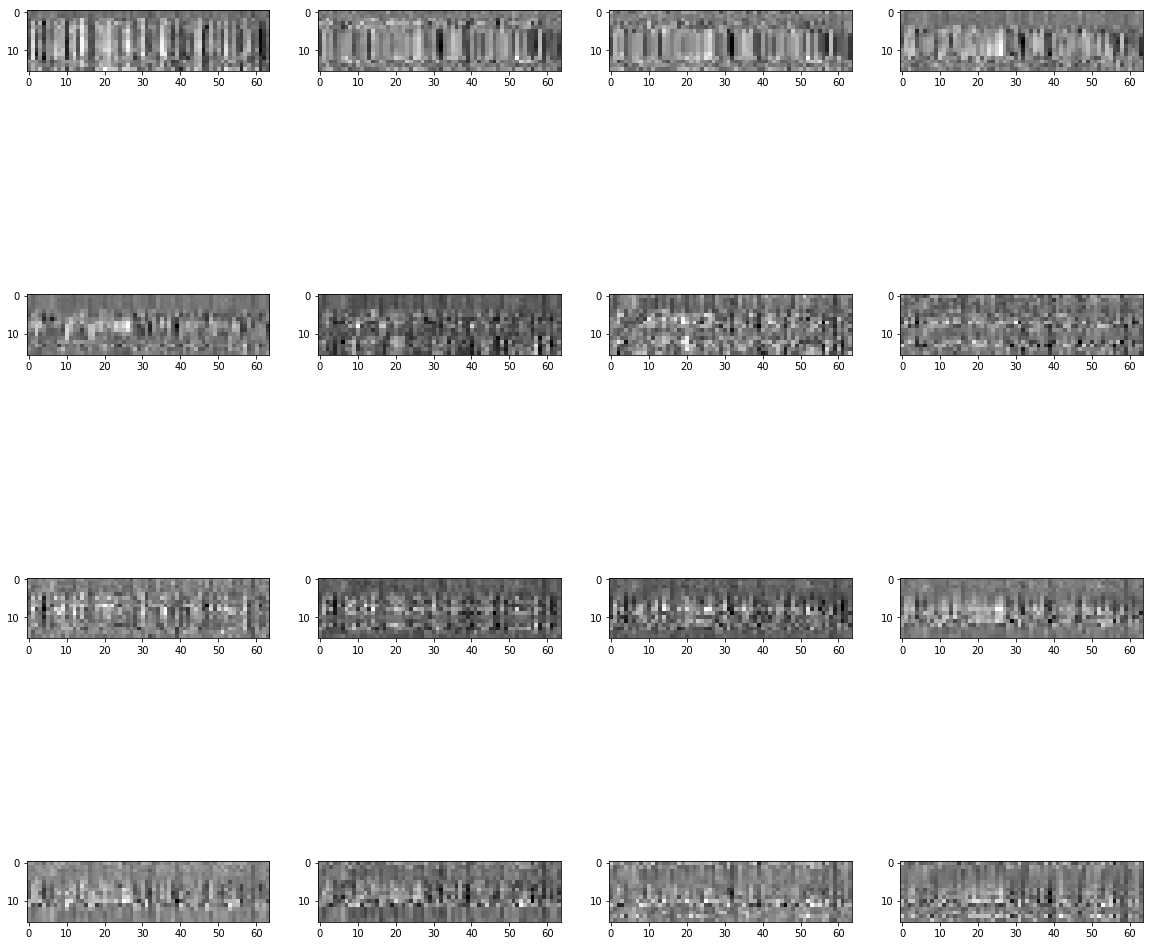

In [56]:
layer_to_visualise(model_driving.layers[5])

In [65]:
status = {0: 'Safe Driving',
             1: 'Unsafe Driving',
             2: 'Moderate Driving',
             3:'Unsafe Driving',
             4:'Moderate Driving',
             5:'Moderate Driving',
             6:'Unsafe Driving',
             7:'Unsafe Driving',
             8:'Unsafe Driving',
             9:'Moderate Driving',
         }

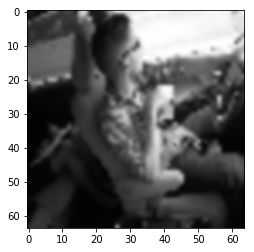

In [90]:
 plt.imshow(np.squeeze(X_test[7]), cmap='gray',interpolation='bicubic')

#### prediction

In [89]:
plt.imshow?

In [82]:
 predict=model_driving.predict_classes(np.array([X_train[6]]))

1/1 [==============================] - 0s


In [85]:
status_driver=status[9]

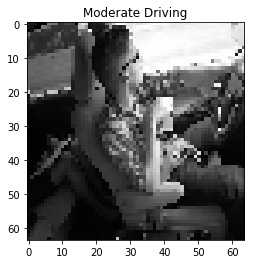

In [86]:
plt.imshow(np.squeeze(X_test[7]), cmap='gray')
plt.title(status[predict[0]])